In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

In [ ]:


t = np.linspace(0.0, 10.0, num=100)
Pt = 0.532421
x = np.sin(2.0*np.pi*t/Pt)
e = np.random.gamma(1, scale=0.2, size=len(x))
y = x + np.random.randn(len(x))*e
plt.figure()
plt.errorbar(t, y, e, fmt='.')
plt.plot(t, x, linewidth=4, alpha=0.25)
plt.figure()
plt.errorbar(np.mod(t, Pt)/Pt, y, e, fmt='.')
N = len(t)

In [ ]:
r = 10
bin_start = np.linspace(0.0, 1.0, num=r+1)
periods = np.arange(0.01, 2.0, step=1e-3)
s_aov = np.zeros(shape=(len(periods),))
yavg = np.average(y, weights=1.0/e**2)
    
for i, P in enumerate(periods):
    phi = np.mod(t, P)/P
    s1 = 0.0
    s2 = 0.0
    for j in range(r):
        idx_bin = np.where(np.logical_and(phi >= bin_start[j], phi < bin_start[j+1]))[0]
        if len(idx_bin) == 0.0:
            continue
        yavgi = np.average(y[idx_bin], weights=1.0/e[idx_bin]**2)
        s1 += len(idx_bin)*(yavgi - yavg)**2
        s2 += np.sum((y[idx_bin] - yavgi)**2)
    s1 = s1/(r-1)
    s2 = s2/(N - r)
    s_aov[i] = s1/s2
    
plt.plot(periods, s_aov)
ylims = plt.ylim()
plt.plot([Pt, Pt], ylims, linewidth=10, alpha=0.25)
_ = plt.ylim(ylims)

In [2]:
from streaming_gmm import lightcurve
import logging


%matplotlib inline
%load_ext autoreload
%autoreload 2

LC_PATH = 'data/lc_1.3444.614.B.mjd'

In [3]:
lightcurve_df = lightcurve.read_from_file(LC_PATH, skiprows=3)
lightcurve_df = lightcurve.remove_unreliable_observations(lightcurve_df)
time, mag, error = lightcurve.unpack_df_in_arrays(lightcurve_df)

0.937


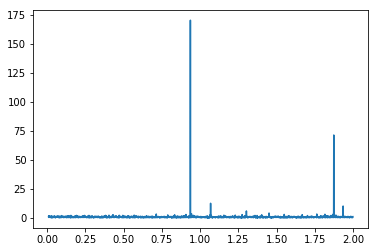

In [4]:
def get_period(time, mag, error):
    r = 10
    bin_start = np.linspace(0.0, 1.0, num=r+1)
    periods = np.arange(0.01, 2.0, step=1e-3)
    s_aov = np.zeros(shape=(len(periods),))
    yavg = np.average(mag, weights=1.0/error**2)
    N = time.shape[0]

    for i, P in enumerate(periods):
        phi = np.mod(time, P)/P
        s1 = 0.0
        s2 = 0.0
        for j in range(r):
            idx_bin = np.where(np.logical_and(phi >= bin_start[j], phi < bin_start[j+1]))[0]
            if len(idx_bin) == 0.0:
                continue
            yavgi = np.average(mag[idx_bin], weights=1.0/error[idx_bin]**2)
            s1 += len(idx_bin)*(yavgi - yavg)**2
            s2 += np.sum((mag[idx_bin] - yavgi)**2)
        s1 = s1/(r-1)
        s2 = s2/(N - r)
        s_aov[i] = s1/s2
    
    return periods, s_aov
    
periods, s_aov = get_period(time, mag, error)
Pt = np.argmax(s_aov)
plt.plot(periods, s_aov)
ylims = plt.ylim()
#plt.plot([Pt, Pt], ylims, linewidth=10, alpha=0.25)
#_ = plt.ylim(ylims)
qq = np.argmax(s_aov)
print(periods[qq])

In [10]:
from streaming_gmm.streaming_lightcurve import to_chunks
from streaming_gmm.streaming_features import StreamingAOV

def calculate_s2(time, mag, error, real_period):
    s2 = 0
    s1 = 0
    s2_false = 0
    yavg = np.average(mag, weights=1.0/error**2)
    print('normal yavg ', yavg)
    phi = np.mod(time, real_period)/real_period
    for j in range(r):
        idx_bin = np.where(np.logical_and(phi >= bin_start[j], phi < bin_start[j+1]))[0]
        if len(idx_bin) == 0.0:
            continue
        yavgi = np.average(mag[idx_bin], weights=1.0/error[idx_bin]**2)
        s1 += len(idx_bin)*(yavgi - yavg)**2
        s2 += np.sum((mag[idx_bin] - yavgi)**2)
        s2_false = np.sum(mag[idx_bin] ** 2) - 2 * yavgi * np.sum(mag[idx_bin]) + len(idx_bin) * yavgi ** 2

r = 10
bin_start = np.linspace(0.0, 1.0, num=r+1)
real_period = 0.937
model = StreamingAOV()
for time, mag, error in to_chunks(lightcurve_df):
    model.update(time, mag, error)
#print('streaming mag avg ', model._magnitude_average)
#print('streaming yavgi ', model._bin_average_map)
#print('streaming mag sq', model._bin_magnitude_sq_sum_map)
#print('streaming mag ', model._bin_magnitude_sum_map)
#print('streaming samples ', model._bin_acumulated_samples)
print('streaming period ', model.get_period())

time, mag, error = lightcurve.unpack_df_in_arrays(lightcurve_df)
calculate_s2(time, mag, error, real_period)
    
#print('streaming final', model._s2)

streaming period  0.937
normal yavg  -5.94212869428


In [ ]:
print(model._s2)

In [ ]:
def f(mag, y):
    return np.sum((mag - y) ** 2)

def f2(mag, y):
    return np.

mag1 = np.random.random(size=10) * 10
mag2 = np.concatenate([mag1, np.random.random(size=10) * 10])

plt.plot(np.arange(-100, 100), np.asarray([f(mag1, y) for y in np.arange(-100, 100)]))
#plt.plot(np.arange(-100, 100), np.asarray([f(mag2, y) for y in np.arange(-100, 100)]))

In [ ]:
y0 = 5
y1 = 7

arr_y1 = np.arange(-100, 100, step=.1)

#f0 = np.sum((mag - y0) ** 2)

def approx_f(mag, y0, y1):
    N = mag.shape[0]
    sq_mag = np.sum(mag ** 2)
    lin_mag = np.sum(mag)
    return sq_mag - 2 * y1 * lin_mag + N * (y1 ** 2)

def f(mag, y1):
    return np.sum((mag - y1) ** 2)

print(approx_f(mag, 0, 3), f(mag, 3))
#plt.plot(arr_y1, np.asarray([approx_f(mag, y0, y) for y in arr_y1]))
#plt.plot(arr_y1, np.asarray([f(mag, y) for y in arr_y1]))